In [4]:
import numpy as np
import pandas as pd
import pickle
import os
import jieba

# load data

In [5]:
with open("./data/data_input.pkl", "rb") as f:
    text_train, label_train, text_test, label_test, label_names = pickle.load(f)

# 分词

In [6]:
def text_to_tokens(text, stop_words = []):
    """
    text: 需要分词的文本
    stop_words: 停用词表，如果有的话
    """
    words = jieba.cut(text)
    tokens = [word for word in words if word not in stop_words]
    return tokens

In [8]:
train_tokens = np.array([text_to_tokens(text) for text in text_train])
test_tokens = np.array([text_to_tokens(text) for text in text_test])

In [9]:
print("train size: ", train_tokens.shape)
print("test size: ", test_tokens.shape)

train size:  (5734,)
test size:  (3656,)


# fasttext 表征文本

In [10]:
import fasttext

# model path 
PROJECT_HOME = "/usr/lib/carter/carter-predictor/"
PRETRAINED_MODEL_PATH = PROJECT_HOME + "pretrained_models/"
FT_MODEL_NAME = 'event_corpus_20181112_fasttext_vec300_epoch50.bin'

# load fasttext model
ft_model = fasttext.load_model(PRETRAINED_MODEL_PATH + FT_MODEL_NAME)
embedding_dim = len(ft_model["上海"])

In [11]:
print("embedding dim:", embedding_dim)

embedding dim: 300


In [25]:
# 词向量序列作为特征
def get_fasttext_sequence(tokens_list, max_sequence_length, model):
    embedding = np.zeros(shape=(max_sequence_length, embedding_dim))
    for i, token in enumerate(tokens_list):
        if token in ft_model.words and i < max_sequence_length:
            embedding[i] = ft_model[token]
        elif token not in ft_model.words and i < max_sequence_length:
            embedding[i] = ft_model["unk"]
        else:
            break
    # padding 
    while i < max_sequence_length:
        embedding[i] = ft_model["blank"]
        i += 1
    return embedding

In [31]:
max_sequence_length = 100  # 文本序列的最大长度 

X_train = np.array([get_fasttext_sequence(tokens, max_sequence_length, ft_model) for tokens in train_tokens])
X_test = np.array([get_fasttext_sequence(tokens, max_sequence_length, ft_model) for tokens in test_tokens])

In [32]:
print("data train shape: ", X_train.shape)
print("data test shape: ", X_test.shape)

data train shape:  (5734, 100, 300)
data test shape:  (3656, 100, 300)


# 训练分类模型

In [41]:
from keras.layers import Dense, Input, Dropout, Bidirectional, CuDNNGRU  # GRU for no cuda version
from keras.models import Model
from keras.utils import to_categorical
import tensorflow as tf
from keras.optimizers import Adam

In [42]:
# 使用gpu
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# 设置定量的GPU使用量
config = tf.ConfigProto()
session = tf.Session(config=config)

# 设置最少显存
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  

In [43]:
Y_train = to_categorical(label_train)
Y_test = to_categorical(label_test)

In [44]:
max_sequence_length = 100
embedding_dim = 300

input_layer = Input(shape=(max_sequence_length, embedding_dim), dtype=float)
rnn_layer = Bidirectional(CuDNNGRU(units=128))(input_layer)
dropout_layer = Dropout(rate=0.2)(rnn_layer)
output_layer = Dense(units=len(label_names), activation="softmax")(dropout_layer)

model = Model(input_layer, output_layer)

In [46]:
optimizer=Adam(lr=0.01)
model.compile(optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [47]:
history = model.fit(x=X_train, y=Y_train, batch_size=32, epochs=20, validation_split=0.1)

Train on 5160 samples, validate on 574 samples
Epoch 1/20
5160/5160 [==============================] - 15s 3ms/step - loss: 1.9066 - acc: 0.4734 - val_loss: 1.3783 - val_acc: 0.5436
Epoch 2/20
5160/5160 [==============================] - 4s 756us/step - loss: 1.1848 - acc: 0.6329 - val_loss: 1.3383 - val_acc: 0.5714
Epoch 3/20
5160/5160 [==============================] - 4s 815us/step - loss: 0.8787 - acc: 0.7132 - val_loss: 1.3294 - val_acc: 0.6446
Epoch 4/20
5160/5160 [==============================] - 4s 789us/step - loss: 0.6541 - acc: 0.7855 - val_loss: 1.6008 - val_acc: 0.5767
Epoch 5/20
5160/5160 [==============================] - 4s 837us/step - loss: 0.4692 - acc: 0.8417 - val_loss: 1.5625 - val_acc: 0.6394
Epoch 6/20
5160/5160 [==============================] - 4s 815us/step - loss: 0.3720 - acc: 0.8721 - val_loss: 1.6856 - val_acc: 0.6185
Epoch 7/20
5160/5160 [==============================] - 4s 753us/step - loss: 0.3810 - acc: 0.8777 - val_loss: 1.8644 - val_acc: 0.5871
Ep

In [48]:
# 训练过程
import matplotlib.pyplot as plt
def plot_accuracy(history):
    fig = plt.figure()
#     plt.subplot(121)
    plt.plot(history.history['acc'],label='training acc')
    plt.plot(history.history['val_acc'],label='val acc')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='lower right')
    plt.show()
    
def plot_loss(history):
#     plt.subplot(121)
    fig = plt.figure()
    plt.plot(history.history['loss'],label='training loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.show()


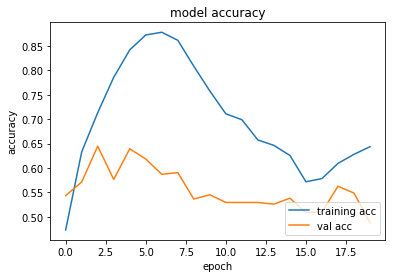

In [50]:
plot_accuracy(history)

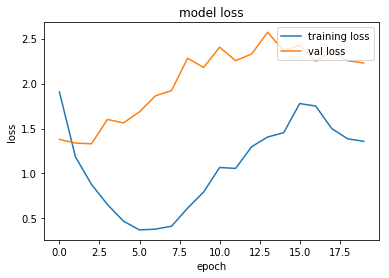

In [52]:
plot_loss(history)

# test

In [53]:
# predict probability
test_prob = model.predict(X_test)

In [54]:
test_pred = [np.argmax(prob) for prob in test_prob]

# evaluation

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_pred= test_pred, y_true=label_test))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65       254
           1       0.67      0.74      0.70       374
           2       0.35      0.57      0.43       310
           3       0.44      0.24      0.31       280
           4       0.60      0.60      0.60       276
           5       0.60      0.30      0.40       175
           6       0.53      0.45      0.48       159
           7       0.52      0.42      0.46       190
           8       0.21      0.11      0.14       164
           9       0.18      0.23      0.20       113
          10       0.68      0.74      0.71       145
          11       0.53      0.60      0.56        47
          12       0.27      0.14      0.19        28
          13       0.61      0.45      0.51        83
          14       0.10      0.05      0.07        60
          15       0.06      0.29      0.10        24
          16       0.65      0.62      0.64        85
          17       0.20    